In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.io.wavfile import read as wavread
import math
import utilities
import features

/Users/saksham/anaconda3/lib/python3.7/site-packages/scipy/__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.2
  UserWarning)


In [2]:
# Read evaluation dataset
path = os.getcwd() + '/flute-audio-labelled-database-AMT/'
audio_path = path + 'Recordings/'
annot_path = path + 'Aligned_files/text_files/'

# Read all wav and txt files and sort the arrays
wav_files = np.sort(glob.glob(os.path.join(audio_path, '*.wav')))
annot_files = np.sort(glob.glob(os.path.join(annot_path,'*.txt')))

# print (len(wav_files), wav_files[0], wav_files[-1])
# print (len(annot_files), annot_files[0], annot_files[-1])

In [3]:
# def block_audio(x, blockSize, hopSize, fs):
#     # allocate memory
#     numBlocks = math.ceil(x.size / hopSize)
#     xb = np.zeros([numBlocks, blockSize])
#     # compute time stamps
#     t = (np.arange(0, numBlocks) * hopSize) / fs
#     x = np.concatenate((x, np.zeros(blockSize)), axis=0)
#     for n in range(0, numBlocks):
#         i_start = n * hopSize
#         i_stop = np.min([x.size - 1, i_start + blockSize - 1])
#         xb[n][np.arange(0, blockSize)] = x[np.arange(i_start, i_stop + 1)]
#     return xb, t

# def compute_spectrogram(xb):
#     numBlocks = xb.shape[0]
#     afWindow = utilities.compute_hann(xb.shape[1])
#     X = np.zeros([math.ceil(xb.shape[1] / 2 + 1), numBlocks])

#     for n in range(0, numBlocks):
#         # apply window
#         tmp = abs(scipy.fftpack.fft(xb[n, :] * afWindow)) * 2 / xb.shape[1]

#         # compute magnitude spectrum
#         X[:, n] = tmp[range(math.ceil(tmp.size / 2 + 1))]
#         X[[0, math.ceil(tmp.size / 2)], n] = X[[0, math.ceil(tmp.size / 2)], n] / np.sqrt(2)
#         # let's be pedantic about normalization
#     return X.T

# def extract_spectral_flux(X):    
    
#     # X = compute_spectrogram(xb)
#     # Compute spectral flux
#     # Initialise blockNum and freqIndex
#     n = 0
#     k = 0

#     spectral_flux = np.zeros(X.shape[0])

#     for n in np.arange(X.shape[0]-1):
#         flux_frame = 0
#         for k in np.arange(X.shape[1]):
#             flux = (abs(X[n+1, k]) - abs(X[n, k]))**2
#             flux_frame += flux
#         flux_frame = np.sqrt(flux_frame)/(X.shape[1]//2+1)
#         spectral_flux[n] = flux_frame
#     return spectral_flux

# def onset_smoothening(envelope, n):
#     # n: filter length - odd
#     fltr = np.ones(n)
#     envelope = np.append(np.zeros(n//2), envelope)
#     envelope = np.append(envelope, np.zeros(n//2))
#     filtered_envelope = np.zeros(len(envelope))
    
#     for i in np.arange(n//2, len(envelope)-n//2):
#         block = envelope[i-n//2:i+n//2+1]
#         avg = np.dot(block, fltr)/n
#         filtered_envelope[i-n//2] = envelope[i]-avg
        
#     return filtered_envelope

# def half_wave_rectification(spectral_flux):
#     envelope = np.max([spectral_flux, np.zeros_like(spectral_flux)], axis = 0)
#     envelope = envelope/max(envelope)
#     return envelope

# def pick_onsets(envelope, thres):
#     peaks = envelope[envelope>thres] 
#     return peaks

# def onset_detect(X, thres, n=5):
#     # n = moving average filter for smoothening the envelope
#     spectral_flux = extract_spectral_flux(X)
#     smoothened_envelope = onset_smoothening(spectral_flux, n)
#     plt.plot(smoothened_envelope)
#     plt.show()
#     # envelope = half_wave_rectification(spectral_flux)
#     peaks = pick_onsets(smoothened_envelope, thres)
#     return peaks

In [4]:
def extract_spectral_flux(X):    
    
    # X = compute_spectrogram(xb)
    # Compute spectral flux
    # Initialise blockNum and freqIndex
    n = 0
    k = 0

    spectral_flux = np.zeros(X.shape[0])

    for n in np.arange(X.shape[0]-1):
        flux_frame = 0
        for k in np.arange(X.shape[1]):
            flux = (abs(X[n+1, k]) - abs(X[n, k]))**2
            flux_frame += flux
        flux_frame = np.sqrt(flux_frame)/(X.shape[1]//2+1)
        spectral_flux[n] = flux_frame
    return spectral_flux

def onset_smoothening(envelope, n):
    # n: filter length - odd
    fltr = np.ones(n)
    envelope = np.append(np.zeros(n//2), envelope)
    envelope = np.append(envelope, np.zeros(n//2))
    filtered_envelope = np.zeros(len(envelope))
    
    for i in np.arange(n//2, len(envelope)-n//2):
        block = envelope[i-n//2:i+n//2+1]
        avg = np.dot(block, fltr)/n
        filtered_envelope[i-n//2] = envelope[i]-avg
        
    return filtered_envelope

def half_wave_rectification(spectral_flux):
    envelope = np.max([spectral_flux, np.zeros_like(spectral_flux)], axis = 0)
    envelope = envelope/max(envelope)
    return envelope

def hz2midi(hz):
    voiced = np.nonzero(hz)[0]
    midi = np.zeros(hz.shape[0])
    midi[voiced] = np.round(69 + 12*np.log2(hz[voiced]/440.))
    return midi

def extract_pitch_chroma(f0c):
    init = 48 #C3
    pitch_classes = np.arange(init, init+12)

    # scale = np.array([48, 50, 51, 53, 55, 56, 58, 60]) # C_MINOR
    pitchChroma = np.zeros([12, f0c.shape[0]])
    midi = hz2midi(f0c)
    
    tmp = midi-init
    
    for i in range(tmp.shape[0]):
        if tmp[i] == -48:
            pitchChroma[:, i] == 0
        if (tmp[i] >= 0) and (tmp[i] < 12):
            pitchChroma[int(tmp[i])-1, i] = 1      # Velocity value #tmp-1
        elif tmp[i] >= 12:
            val = tmp[i] - (int(tmp[i]/12)*12)      #changed tmp to val since there was a def error
            pitchChroma[int(val)-1, i] = 1         # Velocity value 
        elif tmp[i] < 0:
            val = tmp[i] + ((1+int(np.abs(tmp[i]/12)))*12)
            pitchChroma[int(val)-1, i] = 1         # Velocity value
        
    return pitchChroma

In [7]:
"""
Changes:
1. Call functions from packages instead of calling them from the same file
"""

## Edited functions
def pick_onsets(envelope, thres):
    peaks = np.where(envelope>thres)[0]
    return peaks

def onset_detect(X, thres, hopSize, fs, n=5):
    # n = moving average filter for smoothening the envelope
    spectral_flux = extract_spectral_flux(X)
    smoothened_envelope = onset_smoothening(spectral_flux, n)
    envelope = half_wave_rectification(smoothened_envelope)
    envelope = envelope/max(envelope)
    plt.plot(envelope)
    plt.show()
    peaks = pick_onsets(envelope, thres)
    # print (envelope[peaks])
    timestamps = convert_frames_to_time(peaks, hopSize, fs)
    return timestamps

## New functions
def convert_frames_to_time(peaks, hopSize, fs):
    timestamps = peaks*hopSize/fs
    return timestamps

# Read onsets and pitch from a txt file

def read_annot(txtfile):
    # txtfile: Full path of the text file
    with open(txtfile) as f:
        lines = np.array(f.readlines())
        lines = lines[4:-1]
        annot_onset_times = np.array([])
        annot_pitches = np.array([])
        annot_durs = np.array([])
        for data in lines:
            tmp = data.split(' ')
            annot_onset_time = tmp[0]
            annot_onset_times = np.append(annot_onset_times, annot_onset_time)
            annot_pitch = np.float(tmp[2][:-2])
            annot_pitches = np.append(annot_pitches, annot_pitch)
            annot_dur = np.float(tmp[1])
            annot_durs = np.append(annot_durs, annot_dur)
        annot_onset_times = annot_onset_times.astype('float32')
        annot_pitches = annot_pitches.astype('float32')
        annot_durs = annot_durs.astype('float32')
        annot_offsets = annot_onset_times + annot_durs
        return annot_onset_times, annot_pitches, annot_durs, annot_offsets

# Convert pitch annotations to comparable format

def f0_array_from_annot(annot_onsets, annot_durs, annot_pitches, f0, fs, hopSize):

    annot_offsets = annot_onsets + annot_durs

    # 1. Convert timestamps to blocks
    annot_onsets_blocks = (annot_onsets*fs/hopSize).astype(int)
    annot_offsets_blocks = (annot_offsets*fs/hopSize).astype(int)

    # Create pitch array based on annotated blocks
    f0_gt_array = np.zeros(len(f0))
    for i in np.arange(len(annot_onsets_blocks)):
        f0_gt_array[annot_onsets_blocks[i]:annot_offsets_blocks[i]] = annot_pitches[i]

    return f0_gt_array

def convert_freq2midi(freqInHz): 

    """Returns a variable pitchInMIDI of the same dimension as freqInHz. 
    Note that the dimension of freqInHz can be a scalar, a vector, or a matrix. 
    The conversion is described in Textbook Section: 7.2.3. Assume f(A4) = 440Hz."""
    
    pitchInMIDI  =  12*np.log2(freqInHz/440) + 69

    
    return pitchInMIDI

def remove_zero_from_f0(predicted_f0, annot_f0):

    # Removes 0 from predicted f0 based on gt

    gt_final = np.array([])
    predicted_final = np.array([])

    for i in np.arange(len(predicted_f0)):
        if annot_f0[i] != 0:
            gt_final = np.append(gt_final, annot_f0[i])
            predicted_final = np.append(predicted_final, predicted_f0[i])
    return predicted_final, gt_final

def err_rms_cents(pred, gt):
    error = pred-gt
    errorCents = error*100
    errCentRms = (np.dot(errorCents, errorCents)/len(errorCents))**(1/2)

    return errCentRms

Duration:  13.104421768707484


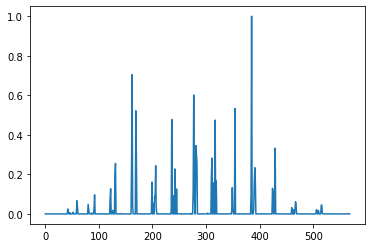

In [8]:
blockSize = 2048
hopSize = blockSize//2
fs = 44100
onset_thres = 0.02



# Evaluate one file
# for i, file in enumerate(wav_files):

i = 10
file = wav_files[i]
# Read audio
fs, x = utilities.ToolReadAudio(file)
print ('Duration: ', len(x)/fs)
# Read annotations for the file
annot_onsets, annot_pitches, annot_durs, annot_offsets = read_annot(annot_files[i])

# Detect onsets from audio file
xb, t = utilities.block_audio(x, blockSize, hopSize, fs)
X = features.compute_spectrogram(xb)

audio_onsets = onset_detect(X, onset_thres, hopSize, fs, n=5)

In [9]:
print ('# Annotated onsets: ', len(annot_onsets))
print ('# Annotated offsets: ', len(annot_offsets))
print ('# Predicted onsets: ', len(audio_onsets))
print ('Annotated onsets timestamps: ', annot_onsets)
print ('Annotated offsets timestamps: ', annot_offsets)
print ('Predicted onsets timestamps: ', audio_onsets)

# Annotated onsets:  13
# Annotated offsets:  13
# Predicted onsets:  59
Annotated onsets timestamps:  [ 1.021875  1.903125  2.832292  3.761458  4.597917  5.479167  6.454167
  7.197917  8.080208  8.9625    9.844792 10.727083 11.748958]
Annotated offsets timestamps:  [ 1.4468751  2.207292   3.136459   4.046875   4.889584   5.765625
  6.630209   7.483334   8.314583   9.171875  10.034375  10.920834
 12.055207 ]
Predicted onsets timestamps:  [ 0.9752381   1.36997732  1.39319728  1.85759637  1.88081633  2.11301587
  2.13623583  2.80961451  2.83283447  3.0185941   3.04181406  3.7384127
  3.76163265  3.78485261  3.92417234  3.94739229  4.62077098  4.66721088
  4.73687075  4.7600907   4.78331066  4.80653061  5.4799093   5.52634921
  5.61922902  5.68888889  6.40870748  6.43192744  6.45514739  6.52480726
  6.54802721  6.57124717  7.19818594  7.2214059   7.2678458   7.36072562
  7.40716553  8.08054422  8.10376417  8.12698413  8.21986395  8.91646259
  8.93968254  9.03256236  9.05578231  9.07900227

In [10]:
"""
# Onset search

1. From the 1st onset, search a 0.05s window for any onset. If onset is found, 
2. then add it to an array to later compute on, and start another scan for next 0.05s. 
3. Repeat the process unless no new onset is found.
4. Find onset - 1. Take max of amplitude of each onset-search section to get onsets or 2. Take avg of timestamp

"""

'\n# Onset search\n\n1. From the 1st onset, search a 0.05s window for any onset. If onset is found, \n2. then add it to an array to later compute on, and start another scan for next 0.05s. \n3. Repeat the process unless no new onset is found.\n4. Find onset - 1. Take max of amplitude of each onset-search section to get onsets or 2. Take avg of timestamp\n\n'

In [11]:
search_range = 0.05 # Range in ms
onsets_cleaned = np.array([])

audio_onsets = audio_onsets.astype('float32')
j = 0

tmps = []
while j <= len(audio_onsets):
    tmp = np.array([audio_onsets[j]])
    while audio_onsets[j+1] - audio_onsets[j] <= 0.05:
        tmp = np.append(tmp, audio_onsets[j+1])
        j += 1
    tmps.append(tmp)

In [ ]:
A = 3
A

In [344]:
search_range = 0.05 # Range in ms
onsets_cleaned = np.array([])

diff = np.diff(audio_onsets.astype('float32'))
clusters = np.where(diff<=0.05)[0]
print (audio_onsets)
# print (diff[clusters])
print (clusters)
print (diff)

for i in np.arange(len(clusters)):
    if i == 0:
        pend = int(clusters[0])
        cluster = audio_onsets[:pend]
        # print (i)
        print ('pin: 0 pend: ', pend)
        print (cluster)
    if i == len(clusters)-1:
        # print (i)
        pin = int(clusters[-1])
        cluster = audio_onsets[pin:]
        print ('pin: ', pin)
        print (cluster)
    elif i > 0 and i < len(clusters):
        pin = int(clusters[i-1])
        pend = int(clusters[i])
        cluster = audio_onsets[pin:pend]
        print ('pin: ', pin, 'pend: ', pend)
        # print (i)
        print (cluster)
        print (diff[pin:pend])
        # print (diff[pin:pend])
        # print (clusters[pin:pend])
    i += 1

# clusters_padded = np.append(0, clusters)
# # print (len(clusters_padded))
# for i in np.arange(len(clusters_padded)):
#     if i == len(clusters_padded)-1:
#         pin = clusters_padded[i]
#         cluster = audio_onsets[pin:]
#         print (cluster)
#     else:
#         pin = clusters_padded[i]
#         pend = clusters_padded[i+1]
#         cluster = audio_onsets[pin:pend]
#         print (cluster)
#     i += 1
#     # print ('pin: ', pin, 'pend: ', pend)
#     # print ('test: ', audio_onsets[pin:pend])

[ 0.9752381   1.36997732  1.39319728  1.85759637  1.88081633  2.11301587
  2.13623583  2.80961451  2.83283447  3.0185941   3.04181406  3.7384127
  3.76163265  3.78485261  3.92417234  3.94739229  4.62077098  4.66721088
  4.73687075  4.7600907   4.78331066  4.80653061  5.4799093   5.52634921
  5.61922902  5.68888889  6.40870748  6.43192744  6.45514739  6.52480726
  6.54802721  6.57124717  7.19818594  7.2214059   7.2678458   7.36072562
  7.40716553  8.08054422  8.10376417  8.12698413  8.21986395  8.91646259
  8.93968254  9.03256236  9.05578231  9.07900227  9.10222222  9.84526077
  9.86848073  9.93814059  9.96136054 10.68117914 10.750839   10.82049887
 10.84371882 10.86693878 11.74929705 11.95827664 11.9814966 ]
[ 1  3  5  7  9 11 12 14 16 18 19 20 22 26 27 29 30 32 33 35 37 38 41 43
 44 45 47 49 53 54 57]
[0.39473927 0.02321994 0.4643991  0.02321994 0.23219955 0.02321982
 0.6733787  0.02322006 0.18575954 0.02322006 0.69659853 0.02322006
 0.02321982 0.1393199  0.02321982 0.6733787  0.04644

In [ ]:
# Open all files
# Read audio from one file
# Read annotation from that file
# Extract pitch and onset from one file
# Compute error in pitch and onset and store them in an array which will be appended for all files
# Onset evaluation - # Total number of onsets and proximity to the closest detected onset
# Pitch evaluation - Pitch class comparison

In [240]:
# Detect f0
rec_duration = 1.0 # Block size to analyse at one go
onsets_thres = 0.8 # Peak picking threshold for onsets
t = -199 # Spectral peak detection threshold in dB for f0 estimation    t changed from -100 to -150
thres_dB = -40 # Voicing mask threshold in dB
f0min = 80
f0max = 2000
w = np.hanning(blockSize)


f0c, f0err = features.f0_detection_TWM(xb, w, blockSize, t, f0min, f0max, fs)
f0 = features.detect_silence(xb, f0c, thres_dB)

# Convert annotations to comparable f0 array
f0_gt_array = f0_array_from_annot(annot_onsets, annot_durs, annot_pitches, f0, fs, hopSize)

# Convert freq to Hz and remove 0s from annotations for evaluations
f0pred_nz, f0gt_nz = remove_zero_from_f0(f0, f0_gt_array)
f0pred_nz_hz = convert_freq2midi(f0pred_nz)
f0gt_nz_hz = convert_freq2midi(f0gt_nz)

errCentRms = err_rms_cents(f0pred_nz_hz, f0gt_nz_hz)
print (errCentRms)

False
inf


/Users/saksham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log2


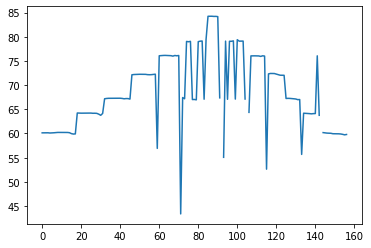

In [235]:
plt.plot(f0pred_nz_hz)

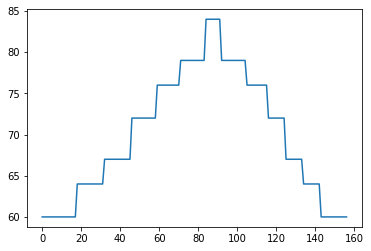

In [236]:
plt.plot(f0gt_nz_hz)

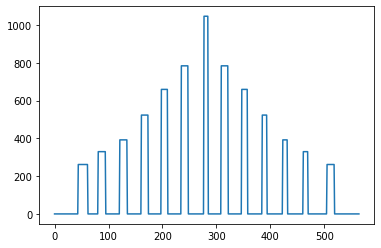

In [228]:
plt.plot(f0_gt_array)

In [225]:
print (annot_onsets, annot_offsets)
print (annot_onsets_blocks, annot_offsets_blocks)

[ 1.021875  1.903125  2.832292  3.761458  4.597917  5.479167  6.454167
  7.197917  8.080208  8.9625    9.844792 10.727083 11.748958] [ 1.4468751  2.207292   3.136459   4.046875   4.889584   5.765625
  6.630209   7.483334   8.314583   9.171875  10.034375  10.920834
 12.055207 ]
[ 44  81 121 161 198 235 277 309 347 385 423 461 505] [ 62  95 135 174 210 248 285 322 358 394 432 470 519]


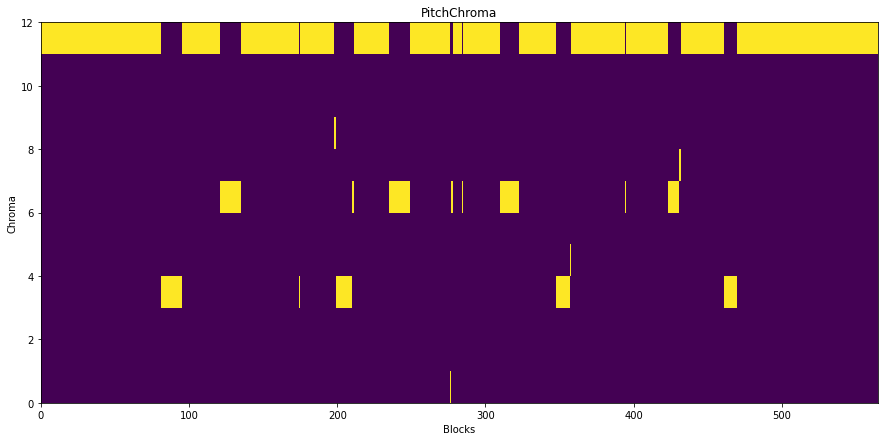

In [188]:
# pitchChroma = features.extract_pitch_chroma(X, fs, 440.)
pitchChroma = features.extract_pitch_chroma(f0)

#plot pitch chroma
plt.figure(figsize=(15, 7))
plt.pcolormesh(pitchChroma)
plt.title("PitchChroma")
plt.xlabel("Blocks")
plt.ylabel("Chroma")
plt.show()

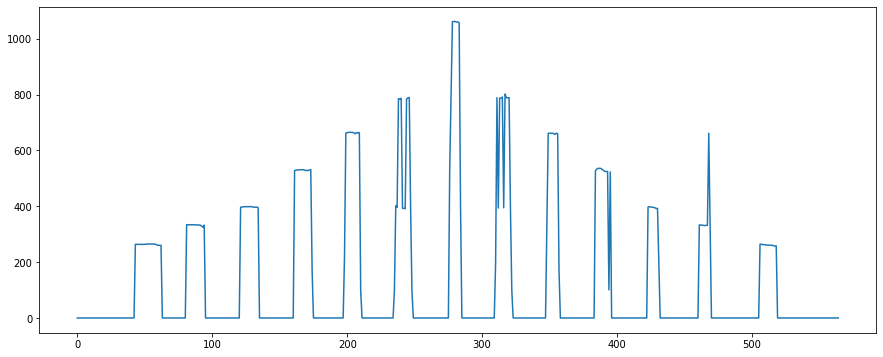

In [189]:
plt.figure(figsize = (15, 6))
plt.plot(f0)

In [181]:
pitchChroma[:, 15]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])